In [66]:
import pandas as pd
import numpy as np
import os
from src.utils.submission import createSubmissionFile
%matplotlib inline 
import sklearn
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [67]:
DATA_FOLDER = '../data/'
CUSTOM_DATA_FOLDER = '../data_custom/'
SUBMISSION_FOLDER = "../submissions/"

In [68]:
train_test_df = pd.read_feather(os.path.join(os.getcwd(), CUSTOM_DATA_FOLDER, 'all_data_preprocessed.feather')).set_index("index")


In [69]:
train_test_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,...,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
index,,,,,,,,,,,,,,,,,,,,,
1497465,4,2,27,0.0,4,0,19,76,42,10,...,0.0,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,0.0,4,0,30,107,42,55,...,0.0,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,0.0,4,0,23,123,42,16,...,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,0.0,4,0,40,4,42,4,...,0.0,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,0.0,4,0,37,4,562,1,...,4.0,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3


In [70]:
def trainXGBoost(train_x, train_y, valid_x=None, valid_y=None, n_estimators=50):
    
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.1,
    #     tree_method='gpu_hist',
        seed=42)
    if valid_x is None : 
        eval_set = None
        early_stopping = None
    else: 
        eval_set = [(train_x, train_y), (valid_x, valid_y)]
        early_stopping = 10
    
    model.fit(
        train_x, 
        train_y, 
        eval_metric="rmse", 
        eval_set=eval_set, 
        verbose=True, 
        early_stopping_rounds = early_stopping)
    
    return model


def trainLR(train_x, train_y):
    lr = LinearRegression()
    lr.fit(train_x.fillna(0).values, train_y.fillna(0))
    return lr

from sklearn import svm
def trainSVM(train_x, train_y):
    regr = svm.LinearSVR()
    regr.fit(train_x.values, train_y)
    return regr

from sklearn.neural_network import MLPRegressor
def trainNN(train_x, train_y):
    regr = MLPRegressor(hidden_layer_sizes=(16, 8), learning_rate="adaptive", verbose=True, max_iter=8)
    regr.fit(train_x.values, train_y)
    return regr

from sklearn.metrics import mean_squared_error
def getRMSE(y_actual, y_predicted):
    rms = mean_squared_error(y_actual.clip(upper=20), y_predicted.clip(max=20), squared=True)
    return rms

In [86]:
#train_test_df.dropna(inplace=True)
all_train_x = train_test_df[train_test_df.date_block_num < 34].drop(['item_cnt_month'], axis=1)
all_train_y = train_test_df[train_test_df.date_block_num < 34]['item_cnt_month'].clip(lower=0, upper=20)

In [72]:
train_x = train_test_df[train_test_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
train_y = train_test_df[train_test_df.date_block_num < 33]['item_cnt_month'].clip(lower=0, upper=20)
valid_x = train_test_df[train_test_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
valid_y = train_test_df[train_test_df.date_block_num == 33]['item_cnt_month'].clip(lower=0, upper=20)
test_x = train_test_df[train_test_df.date_block_num == 34].drop(['item_cnt_month'], axis=1)



In [8]:
%%time
xgboost_model = trainXGBoost(train_x, train_y, valid_x, valid_y)

[0]	validation_0-rmse:3.30702	validation_1-rmse:2.57119
[1]	validation_0-rmse:3.11013	validation_1-rmse:2.42601
[2]	validation_0-rmse:2.93720	validation_1-rmse:2.33563
[3]	validation_0-rmse:2.78519	validation_1-rmse:2.23261
[4]	validation_0-rmse:2.66091	validation_1-rmse:2.16893
[5]	validation_0-rmse:2.53736	validation_1-rmse:2.16746
[6]	validation_0-rmse:2.42698	validation_1-rmse:2.13580
[7]	validation_0-rmse:2.34183	validation_1-rmse:2.09298
[8]	validation_0-rmse:2.25882	validation_1-rmse:2.14974
[9]	validation_0-rmse:2.18267	validation_1-rmse:2.13703
[10]	validation_0-rmse:2.11745	validation_1-rmse:2.19043
[11]	validation_0-rmse:2.05874	validation_1-rmse:2.17822
[12]	validation_0-rmse:2.00782	validation_1-rmse:2.18304
[13]	validation_0-rmse:1.95857	validation_1-rmse:2.17637
[14]	validation_0-rmse:1.91779	validation_1-rmse:2.23152
[15]	validation_0-rmse:1.88218	validation_1-rmse:2.22666
[16]	validation_0-rmse:1.85394	validation_1-rmse:2.23142
[17]	validation_0-rmse:1.82557	validation

In [9]:
%%time

lr_model = trainLR(train_x.fillna(0), train_y.fillna(0))

Wall time: 5.81 s


In [10]:
%%time
svm_model = trainSVM(train_x.fillna(0), train_y.fillna(0))

Wall time: 1h 6min 51s


C:\Users\feder\Anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [11]:
%%time
nn_model = trainNN(train_x.fillna(0), train_y.fillna(0))


Iteration 1, loss = 106536.68329027
Iteration 2, loss = 6.35411209
Iteration 3, loss = 6.27230639
Iteration 4, loss = 6.27028393
Iteration 5, loss = 6.27019347
Iteration 6, loss = 6.27017521
Iteration 7, loss = 6.27017232
Iteration 8, loss = 6.27018787
Wall time: 7min 49s


C:\Users\feder\Anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
xgboost_predictions = xgboost_model.predict(valid_x, ntree_limit=xgboost_model.best_ntree_limit)
lr_predictions = lr_model.predict(valid_x.fillna(0))
sv_predictions = svm_model.predict(valid_x.fillna(0))
nn_predictions = nn_model.predict(valid_x.fillna(0))

xgboost_score = getRMSE(valid_y, xgboost_predictions)
lr_score = getRMSE(valid_y, lr_predictions)
svm_score = getRMSE(valid_y, sv_predictions)
nn_score = getRMSE(valid_y, nn_predictions)
print("XGB score: {}, LRScore: {}, SVMScore: {}, NNScore: {}".format(xgboost_score, lr_score, svm_score, nn_score))

XGB score: 0.877622663974762, LRScore: 0.9578894972801208, SVMScore: 1.1564089725702447, NNScore: 1.2984035473709565


Best alpha: 0.719000; Corresponding r2 score on train: 0.862250


In [ ]:
xgb_complete = trainXGBoost(all_train_x, all_train_y, n_estimators=7)
test_predict_xgb = xgb_complete.predict(test_x)

xgb_result = test_x.copy()
xgb_result["ID"] = range(len(xgb_result))
xgb_result["item_cnt_month"] = test_predict_xgb
createSubmissionFile(xgb_result, "xgb_improvedmodel_simple_result.csv")
del xgb_complete

In [64]:
lr_complete = trainLR(all_train_x.fillna(0), all_train_y)
test_predict_lr = lr_complete.predict(test_x.fillna(0))
lr_result = test_x.copy()
lr_result["ID"] = range(len(lr_result))
lr_result["item_cnt_month"] = test_predict_lr
createSubmissionFile(lr_result, "lr_simple_result.csv")


In [32]:
xgb_complete = trainXGBoost(all_train_x, all_train_y, n_estimators=7)
test_predict_xgb = xgb_complete.predict(test_x)

lr_complete = trainLR(all_train_x.fillna(0), all_train_y)
test_predict_lr = lr_complete.predict(test_x.fillna(0))

alpha = 0.719
test_predict = alpha * test_predict_xgb + ((1 - alpha) * test_predict_lr)

lr_result = test_x.copy()
lr_result["ID"] = range(len(lr_result))
lr_result["item_cnt_month"] = test_predict_lr
createSubmissionFile(lr_result, "lr_xgb_sample_ensamgling.csv")


# Ensambling


In [76]:
number_of_model = 2

In [77]:
train_x.head()

,date_block_num,shop_id,item_id,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,...,date_shop_item_avg_item_cnt_lag_3,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
index,,,,,,,,,,,,,,,,,,,,,
1497465,4,2,27,4,0,19,76,42,10,3,...,0.0,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,4,0,30,107,42,55,3,...,0.0,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,4,0,23,123,42,16,3,...,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,4,0,40,4,42,4,5,...,0.0,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,4,0,37,4,562,1,5,...,4.0,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3


In [91]:
dates_to_consider = train_x["date_block_num"].isin([27, 28, 29, 30, 31, 32])
# That is how we get target for the 2nd level dataset
y_train_level2 = train_y[dates_to_consider]

In [95]:
%%time
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], number_of_model])
last_index = 0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    date_filter = train_x["date_block_num"] < cur_block_num
    x_train_M = train_x[date_filter]
    y_train_M = train_y[date_filter]
    x_test_M = train_x[train_x["date_block_num"].isin([cur_block_num])]
    pred_number = len(x_test_M)
    print("Last index: {}, pred_number: {}".format(last_index, pred_number))
    
    lr = trainLR(x_train_M, y_train_M)
    pred_lr = lr.predict(x_test_M.fillna(0).values).clip(0, 20)
    X_train_level2[last_index:(last_index + pred_number), 0] = pred_lr
    
    xgb = trainXGBoost(x_train_M, y_train_M, n_estimators=10)
    pred_lgb = xgb.predict(x_test_M).clip(0, 20)
    X_train_level2[last_index:(last_index + pred_number), 1] = pred_lgb
    
    last_index = pred_number + last_index
    

27
Last index: 0, pred_number: 257372
28
Last index: 257372, pred_number: 232452
29
Last index: 489824, pred_number: 224288
30
Last index: 714112, pred_number: 228889
31
Last index: 943001, pred_number: 214536
32
Last index: 1157537, pred_number: 218655
Wall time: 15min 35s


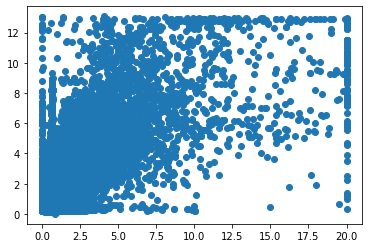

In [96]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])


In [97]:

alphas_to_try = np.linspace(0, 1, 1001)

results = []
for alpha in alphas_to_try:
    lr_predictions = X_train_level2[:, 0]
    xgboost_predictions = X_train_level2[:, 1]
    pred = alpha * xgboost_predictions + ((1 - alpha) * lr_predictions)
    score_res = getRMSE(y_train_level2, pred)
    results.append([alpha, score_res])
    

res_array = np.asarray(results)
best_index = np.argmin(res_array[:, 1])
best_alpha = res_array[best_index, 0]
r2_train_simple_mix = res_array[best_index, 1]

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))
# prima qua faceva 0.7156

Best alpha: 1.000000; Corresponding r2 score on train: 0.715685


In [98]:
lr_stack = LinearRegression()
lr_stack.fit(X_train_level2, y_train_level2)

LinearRegression()

In [99]:
train_preds = lr_stack.predict(X_train_level2)
r2_train_stacking = getRMSE(y_train_level2, train_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)

# prima qua faceva 0.65069

Train R-squared for stacking is 0.650531


In [109]:
xgb_complete_train = trainXGBoost(train_x, train_y, valid_x, valid_y, n_estimators=1000)
test_predict_xgb = xgb_complete_train.predict(valid_x)

[0]	validation_0-rmse:1.17824	validation_1-rmse:1.11808
[1]	validation_0-rmse:1.12326	validation_1-rmse:1.08090
[2]	validation_0-rmse:1.07854	validation_1-rmse:1.04858
[3]	validation_0-rmse:1.04514	validation_1-rmse:1.02205
[4]	validation_0-rmse:1.01694	validation_1-rmse:1.00391
[5]	validation_0-rmse:0.98735	validation_1-rmse:0.98535
[6]	validation_0-rmse:0.96416	validation_1-rmse:0.97020
[7]	validation_0-rmse:0.94503	validation_1-rmse:0.95805
[8]	validation_0-rmse:0.92828	validation_1-rmse:0.94900
[9]	validation_0-rmse:0.91393	validation_1-rmse:0.94011
[10]	validation_0-rmse:0.89921	validation_1-rmse:0.93351
[11]	validation_0-rmse:0.88733	validation_1-rmse:0.92853
[12]	validation_0-rmse:0.87790	validation_1-rmse:0.92266
[13]	validation_0-rmse:0.86954	validation_1-rmse:0.91815
[14]	validation_0-rmse:0.86150	validation_1-rmse:0.91481
[15]	validation_0-rmse:0.85460	validation_1-rmse:0.91250
[16]	validation_0-rmse:0.85010	validation_1-rmse:0.91111
[17]	validation_0-rmse:0.84472	validation

In [110]:
lr_complete = trainLR(train_x.fillna(0), train_y)
test_predict_lr = lr_complete.predict(valid_x.fillna(0))

In [123]:
test_predict_xgb = xgb_complete_train.predict(valid_x).clip(0, 20)
test_predict_lr = lr_complete.predict(valid_x.fillna(0)).clip(0, 20)
concateated_predictions = np.c_[test_predict_lr, test_predict_xgb]

lr_stack_train = LinearRegression()
lr_stack_train.fit(concateated_predictions, valid_y)

LinearRegression()

In [124]:
valid_preds = lr_stack.predict(np.c_[test_predict_lr, test_predict_xgb])
r2_test_stacking = getRMSE(valid_y, valid_preds)

test_predict_xgb = xgb_complete_train.predict(test_x).clip(0, 20)
test_predict_lr = lr_complete.predict(test_x.fillna(0)).clip(0, 20)
test_preds = lr_stack_train.predict(np.c_[test_predict_lr, test_predict_xgb])

ensambling_result = test_x.copy()
ensambling_result["ID"] = range(len(ensambling_result))
ensambling_result["item_cnt_month"] = test_preds.clip(max=20, min=0)
createSubmissionFile(ensambling_result, "lr_xgb_stacking_0_20_validation_out_validation_stacking.csv")

print('Test  R-squared for stacking is %f' % r2_test_stacking)
# prima Test  R-squared for stacking is 0.970194

Test  R-squared for stacking is 0.954803


In [126]:
xgb_complete = trainXGBoost(all_train_x, all_train_y, n_estimators=60)
test_predict_xgb = xgb_complete.predict(test_x).clip(0, 20)

In [127]:
lr_complete = trainLR(all_train_x, all_train_y)
test_predict_lr = lr_complete.predict(test_x.fillna(0)).clip(0, 20)

In [128]:
all_train_predict_xgb = xgb_complete.predict(all_train_x).clip(0, 20)
all_train_predict_lr = lr_complete.predict(all_train_x.fillna(0)).clip(0, 20)
concateated_predictions = np.c_[all_train_predict_lr, all_train_predict_xgb]

lr_stack_all_train = LinearRegression()
lr_stack_all_train.fit(concateated_predictions, all_train_y)

LinearRegression()

In [129]:
test_preds = lr_stack_all_train.predict(np.c_[test_predict_lr, test_predict_xgb])

In [130]:
ensambling_result = test_x.copy()
ensambling_result["ID"] = range(len(ensambling_result))
ensambling_result["item_cnt_month"] = test_preds.clip(max=20, min=0)
createSubmissionFile(ensambling_result, "lr_xgb_stacking_0_20_retrained_stacking.csv")


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

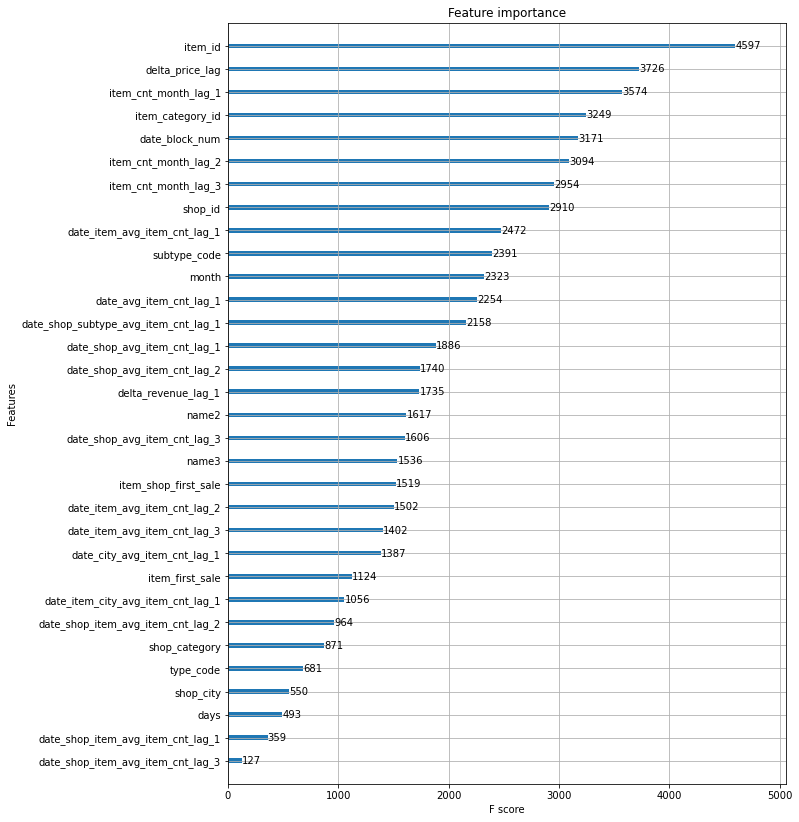

In [74]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_complete_train, (10,14))

In [75]:
final_test_predict_xgb = xgb_complete_train.predict(test_x)

xgb_no_valid_result = test_x.copy()
xgb_no_valid_result["ID"] = range(len(xgb_no_valid_result))
xgb_no_valid_result["item_cnt_month"] = final_test_predict_xgb.clip(max=20, min=0)
createSubmissionFile(xgb_no_valid_result, "xgb_no_valid.csv")